In [97]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

In [98]:
test_size = 0.3              
cv_size = 0.2                  # пропорция для кросс валидации
N = 3                         # кол-во лагов

n_estimators = 100 
max_depth = 3
learning_rate = 0.1


fontsize = 14
ticklabelsize = 14

In [99]:
def get_mov_avg_std(df, col, N):
    mean_list = df[col].rolling(window = N, min_periods=1).mean()
    std_list = df[col].rolling(window = N, min_periods=1).std()  
    
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    

    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled


def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1):


    model = GradientBoostingRegressor(
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate)
    

    model.fit(X_train_scaled, y_train_scaled)
    

    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean


    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [100]:
df = pd.read_csv('AXP.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,40.810001,41.099998,40.389999,40.919998,34.405621,6894300
1,2010-01-05,40.830002,41.230000,40.369999,40.830002,34.329956,10641200
2,2010-01-06,41.230000,41.669998,41.169998,41.490002,34.884884,8399400
3,2010-01-07,41.259998,42.240002,41.110001,41.980000,35.450680,8981700
4,2010-01-08,41.759998,42.480000,41.400002,41.950001,35.425346,7907700
...,...,...,...,...,...,...,...
2511,2019-12-24,124.949997,125.330002,124.379997,124.739998,121.757988,953500
2512,2019-12-26,124.980003,125.440002,124.529999,125.410004,122.411972,1486600
2513,2019-12-27,125.839996,125.970001,125.110001,125.190002,122.197235,1788600
2514,2019-12-30,125.199997,125.459999,124.180000,124.300003,121.328506,2306500


In [101]:
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

df['month'] = df['date'].dt.month

df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2010-01-04,40.810001,41.099998,40.389999,40.919998,34.405621,6894300,1
1,2010-01-05,40.830002,41.230000,40.369999,40.830002,34.329956,10641200,1
2,2010-01-06,41.230000,41.669998,41.169998,41.490002,34.884884,8399400,1
3,2010-01-07,41.259998,42.240002,41.110001,41.980000,35.450680,8981700,1
4,2010-01-08,41.759998,42.480000,41.400002,41.950001,35.425346,7907700,1


Text(0, 0.5, 'AXP')

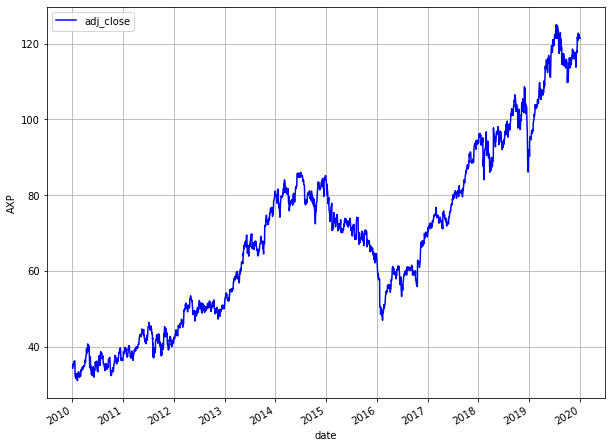

In [102]:
rcParams['figure.figsize'] = 10, 8 

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel('date')
ax.set_ylabel('AXP')

In [103]:
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2010-01-04,34.405621,6894300,1,0.709999,-0.109997
1,2010-01-05,34.329956,10641200,1,0.860001,0.000000
2,2010-01-06,34.884884,8399400,1,0.500000,-0.260002
3,2010-01-07,35.450680,8981700,1,1.130001,-0.720002
4,2010-01-08,35.425346,7907700,1,1.079998,-0.190003


In [104]:
df['order_day'] = [x for x in list(range(len(df)))]

merging_keys = ['order_day']

lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']

In [105]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left')
    
del train_shift

df = df[N:]
    
df.head()

<ipython-input-105-f82c6ad0f159>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2010-01-07,35.450680,8981700,1,1.130001,-0.720002,3,34.884884,0.500000,-0.260002,8399400.0,34.329956,0.860001,0.000000,10641200.0,34.405621,0.709999,-0.109997,6894300.0
4,2010-01-08,35.425346,7907700,1,1.079998,-0.190003,4,35.450680,1.130001,-0.720002,8981700.0,34.884884,0.500000,-0.260002,8399400.0,34.329956,0.860001,0.000000,10641200.0
5,2010-01-11,35.019997,7396000,1,0.709999,0.270001,5,35.425346,1.079998,-0.190003,7907700.0,35.450680,1.130001,-0.720002,8981700.0,34.884884,0.500000,-0.260002,8399400.0
6,2010-01-12,35.484455,12657300,1,1.099998,-0.750000,6,35.019997,0.709999,0.270001,7396000.0,35.425346,1.079998,-0.190003,7907700.0,35.450680,1.130001,-0.720002,8981700.0
7,2010-01-13,35.594231,10137200,1,0.670002,-0.300004,7,35.484455,1.099998,-0.750000,12657300.0,35.019997,0.709999,0.270001,7396000.0,35.425346,1.079998,-0.190003,7907700.0


In [106]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2010-01-07,35.450680,8981700,1,1.130001,-0.720002,3,34.884884,0.500000,-0.260002,...,-0.109997,6894300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,35.425346,7907700,1,1.079998,-0.190003,4,35.450680,1.130001,-0.720002,...,0.000000,10641200.0,35.450680,NaN,1.130001,NaN,-0.720002,NaN,8.981700e+06,NaN
5,2010-01-11,35.019997,7396000,1,0.709999,0.270001,5,35.425346,1.079998,-0.190003,...,-0.260002,8399400.0,35.438013,0.017914,1.104999,0.035357,-0.455003,0.374766,8.444700e+06,7.594327e+05
6,2010-01-12,35.484455,12657300,1,1.099998,-0.750000,6,35.019997,0.709999,0.270001,...,-0.720002,8981700.0,35.298674,0.241674,0.973333,0.229420,-0.213335,0.495414,8.095133e+06,8.092957e+05
7,2010-01-13,35.594231,10137200,1,0.670002,-0.300004,7,35.484455,1.099998,-0.750000,...,-0.190003,7907700.0,35.309933,0.252825,0.963332,0.219620,-0.223334,0.510817,9.320333e+06,2.901201e+06


In [107]:

num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1258
num_cv = 502
num_test = 753
train.shape = (1258, 27)
cv.shape = (502, 27)
train_cv.shape = (1760, 27)
test.shape = (753, 27)


In [108]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))


scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 5.43491598e+01  5.43132822e+01  1.08077892e+00 -2.08982671e-02
  6.59701558e+06  5.42755784e+01  1.07950706e+00 -2.24086017e-02
  6.60271638e+06  5.42361692e+01  1.07864060e+00 -2.26152774e-02
  6.60625914e+06]
scaler.var_ = [2.89868645e+02 2.89644723e+02 2.72225346e-01 5.08098440e-01
 1.72162485e+13 2.89361851e+02 2.70750354e-01 5.05163395e-01
 1.72214423e+13 2.88972638e+02 2.70445487e-01 5.05145821e-01
 1.72077063e+13]
train_scaled.shape = (1258, 13)
train_scaled.shape = (1258, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.110008,-1.141574,-1.113132,-0.335438,0.434388,-1.172538,-0.421854,0.031528,0.973158,-1.166558,-0.708867,-0.122945,0.069437,2010-01-07,1
1,-1.111496,-1.108329,0.094340,-0.980771,0.574727,-1.139916,-1.113715,-0.334286,0.432949,-1.171009,-0.420425,0.031820,0.972693,2010-01-08,1
2,-1.135305,-1.109818,-0.001497,-0.237237,0.315885,-1.106654,0.097041,-0.981491,0.573267,-1.138365,-1.112677,-0.334001,0.432268,2010-01-11,1
3,-1.108025,-1.133635,-0.710644,0.408102,0.192561,-1.108144,0.000944,-0.235800,0.314464,-1.105081,0.098762,-0.981218,0.572641,2010-01-12,1
4,-1.101577,-1.106345,0.036836,-1.022855,1.460575,-1.131973,-0.710133,0.411411,0.191159,-1.106571,0.002610,-0.235513,0.313735,2010-01-13,1


In [109]:

scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 5.73702228e+01  5.73500930e+01  1.08578970e+00 -1.71818472e-02
  6.41956631e+06  5.73303213e+01  1.08599425e+00 -1.71136636e-02
  6.42369267e+06  5.73106774e+01  1.08572720e+00 -1.73750250e-02
  6.42614756e+06]
scaler_train_cv.var_ = [2.45501146e+02 2.45692825e+02 2.85619543e-01 5.07181492e-01
 1.69108344e+13 2.45914708e+02 2.85453496e-01 5.07175648e-01
 1.69156901e+13 2.46135830e+02 2.85528728e-01 5.07103907e-01
 1.69073881e+13]
train_cv_scaled.shape = (1760, 13)
train_cv_scaled.shape = (1760, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.398958,-1.433225,-1.096094,-0.340960,0.481444,-1.466704,-0.422988,0.024031,1.025442,-1.459970,-0.703151,-0.130067,0.113854,2010-01-07,1
1,-1.400575,-1.397128,0.082725,-0.986876,0.623045,-1.431317,-1.096796,-0.341057,0.480372,-1.464793,-0.422432,0.024399,1.025096,2010-01-08,1
2,-1.426445,-1.398744,-0.010837,-0.242670,0.361876,-1.395237,0.082367,-0.986977,0.621952,-1.429422,-1.096151,-0.340714,0.479893,2010-01-11,1
3,-1.396803,-1.424605,-0.703157,0.403252,0.237443,-1.396852,-0.011223,-0.242767,0.360820,-1.393358,0.082856,-0.986680,0.621508,2010-01-12,1
4,-1.389796,-1.394973,0.026586,-1.028998,1.516856,-1.422701,-0.703744,0.403159,0.236406,-1.394973,-0.010722,-0.242417,0.360312,2010-01-13,1


In [110]:

cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)

cv_scaled.head()

<ipython-input-110-1a8893882e1c>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1261,2015-01-07,-0.957436,-0.080288,1.037724,0.951014,0.091661,-1.042675,0.692174,0.454332,-1.146506,1.039362,-0.084027,-0.955335
1262,2015-01-08,0.579893,-1.154697,0.574804,-1.089178,0.876657,0.212521,-1.138259,0.737283,0.400976,0.922389,0.140385,-1.062775
1263,2015-01-09,0.926195,0.134081,-1.060276,-0.854441,-0.245422,1.099863,-0.902860,-0.171975,1.074834,-1.027172,0.970410,0.056762
1264,2015-01-12,-0.490394,1.150534,-0.660140,0.671742,-1.149242,0.477500,0.883604,-1.085567,0.201963,-0.618173,-0.535542,1.153715
1265,2015-01-13,-0.959409,-0.076759,1.036168,0.832046,0.277357,-1.109402,0.460808,0.686516,-1.147324,-1.140002,0.410951,0.729051


In [111]:

test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
test_scaled.head()

<ipython-input-111-be793e55e2a8>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1763,2017-01-04,1.148664,-0.472211,-0.676453,0.320260,-1.120898,0.800638,-0.942462,-0.106545,1.049006,1.122229,-0.325634,-0.796595
1764,2017-01-05,0.995345,0.009246,-1.004591,0.989748,0.020198,-1.009946,-1.066616,0.150232,0.916385,0.010477,0.994720,-1.005197
1765,2017-01-06,-0.336976,1.124958,-0.787982,0.295378,0.819039,-1.114417,1.095991,-0.862802,-0.233189,-1.004648,0.009362,0.995286
1766,2017-01-09,-0.422434,-0.719461,1.141895,-1.132436,0.370791,0.761645,0.071293,0.962446,-1.033739,-0.746702,-0.389425,1.136127
1767,2017-01-10,1.112118,-0.286995,-0.825123,-0.355226,-0.773892,1.129117,-0.044416,-0.977052,1.021468,1.140096,-0.728591,-0.411505


In [112]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1258, 12)
y_train.shape = (1258,)
X_cv.shape = (502, 12)
y_cv.shape = (502,)
X_train_cv.shape = (1760, 12)
y_train_cv.shape = (1760,)
X_sample.shape = (753, 12)
y_sample.shape = (753,)


In [113]:

X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1258, 12)
y_train_scaled.shape = (1258,)
X_cv_scaled.shape = (502, 12)
X_train_cv_scaled.shape = (1760, 12)
y_train_cv_scaled.shape = (1760,)
X_sample_scaled.shape = (753, 12)


Text(0.5, 1.0, 'Without scaling')

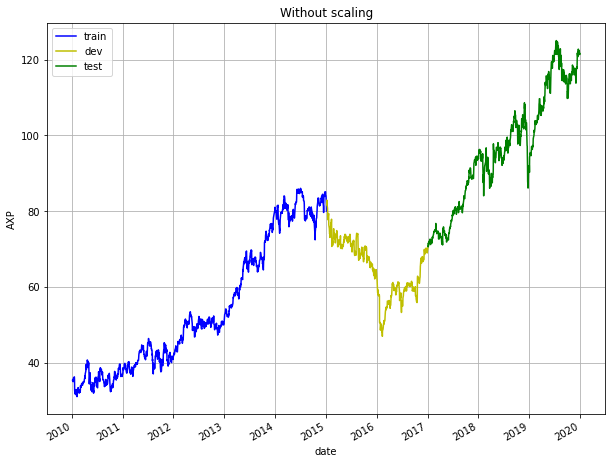

In [114]:

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("AXP")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

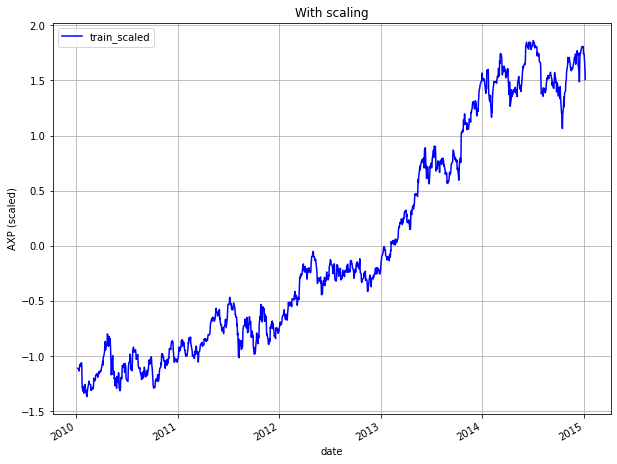

In [115]:

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("AXP (scaled)")
ax.set_title("With scaling")

In [116]:

model = GradientBoostingRegressor(
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate)

model.fit(X_train_scaled, y_train_scaled)

GradientBoostingRegressor()

In [117]:

est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.564
MAPE on train set = 0.872%


Text(0.5, 1.0, 'Without scaling')

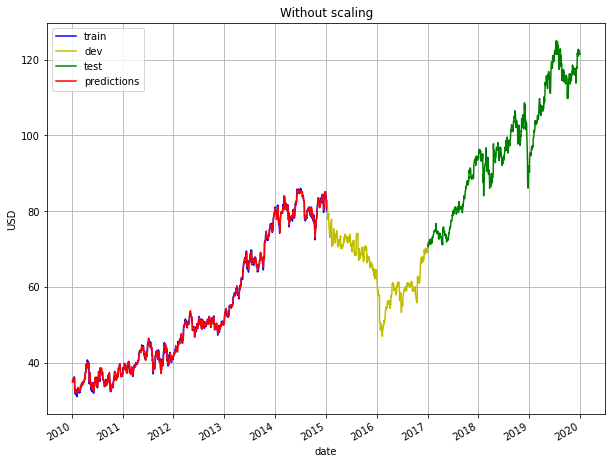

In [118]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [119]:

est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']


rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)


mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 1.026
MAPE on dev set = 1.073%


<ipython-input-119-f6b414479798>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
<ipython-input-119-f6b414479798>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']


Text(0, 0.5, 'AXP')

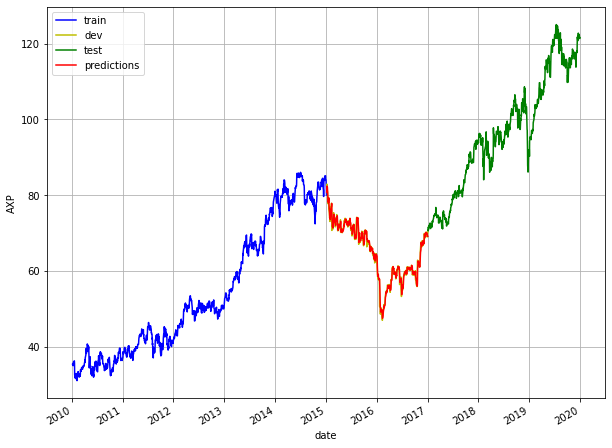

In [120]:

rcParams['figure.figsize'] = 10, 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("AXP")

Text(0.5, 1.0, 'Zoom in to dev set')

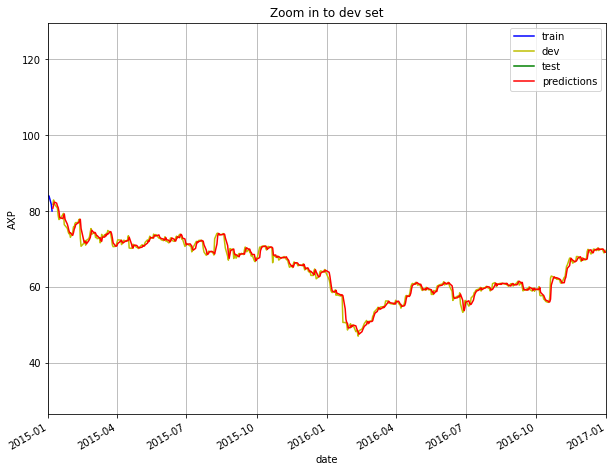

In [122]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("AXP")
ax.set_xlim([date(2015, 1, 1), date(2017, 1, 1)])
ax.set_title("Zoom in to dev set")

In [123]:

imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_hl_lag_3', 3.920237163367193e-05),
 ('range_hl_lag_1', 4.1989514490947926e-05),
 ('range_hl_lag_2', 5.1622575286005385e-05),
 ('range_oc_lag_1', 6.221168291451361e-05),
 ('range_oc_lag_2', 6.669575288188362e-05),
 ('volume_lag_1', 7.026150646323693e-05),
 ('volume_lag_3', 7.4289405107922e-05),
 ('adj_close_lag_3', 0.11212447832428091),
 ('adj_close_lag_2', 0.3492149998944333),
 ('adj_close_lag_1', 0.5381932806868299)]

In [124]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


In [125]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in param2_list:

        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate)
   
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-125-8acab223f853>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):



Minutes taken = 3.6585989316304524


,n_estimators,max_depth,rmse,mape_pct
0,10,2,1.025363,1.078282
1,10,3,1.080301,1.137995
2,10,4,1.051084,1.107263
3,10,5,1.077078,1.129848
4,10,6,1.104241,1.155745
...,...,...,...,...
235,300,5,1.037699,1.082243
236,300,6,1.081822,1.123217
237,300,7,1.106032,1.146711
238,300,8,1.167897,1.203503


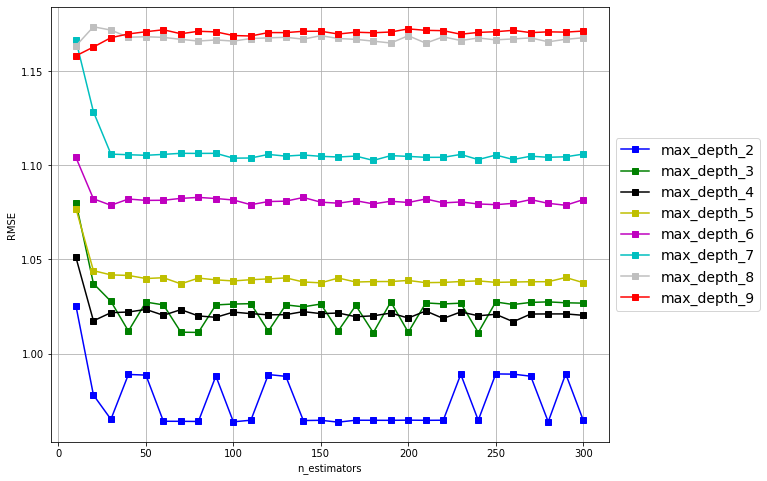

In [126]:

rcParams['figure.figsize'] = 10, 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))

In [127]:

temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.964
optimum params = 


(160, 2)

In [128]:

temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.009%
optimum params = 


(280, 2)

In [130]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]


error_rate = {param_label: [] ,'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):

    
    for param2 in param2_list:
  
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param)
    

        error_rate[param_label].append(param)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-130-ea5a086db6ac>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):



Minutes taken = 0.3642915844917297


,learning_rate,rmse,mape_pct
0,0.001,1.171799,1.250387
1,0.001,1.171949,1.250545
2,0.001,1.171647,1.250228
3,0.001,1.171571,1.250147
4,0.001,1.171571,1.250148
5,0.001,1.171871,1.250463
6,0.001,1.171801,1.250390
7,0.001,1.171951,1.250548
8,0.005,1.095140,1.159919
9,0.005,1.095120,1.159890


In [133]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt

min RMSE = 0.962
optimum params = 


0.2

In [134]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,160.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.200
3,rmse,1.026,0.962
4,mape_pct,1.073,1.009


In [135]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt)

print("RMSE on test set = %0.3f" % rmse)

print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 1.151
MAPE on test set = 0.822%


Text(0.5, 1.0, 'AXP prices over given period')

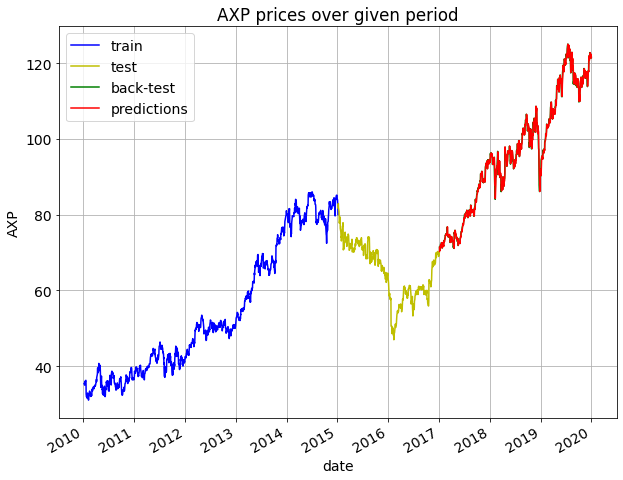

In [145]:

rcParams['figure.figsize'] = 10, 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'back-test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("AXP")
ax.set_title("AXP prices over given period")

Text(0.5, 1.0, 'Zoom in to test set')

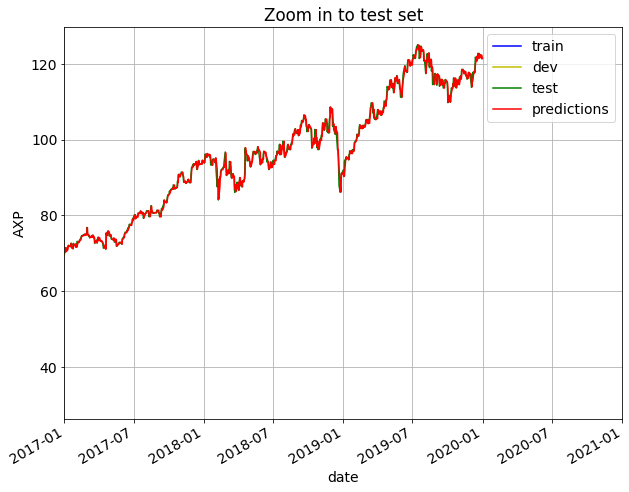

In [143]:

rcParams['figure.figsize'] = 10, 8 
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("AXP")
ax.set_xlim([date(2017, 1, 1), date(2021, 1, 1)])
ax.set_title("Zoom in to test set")

(17167.0, 18628.0)

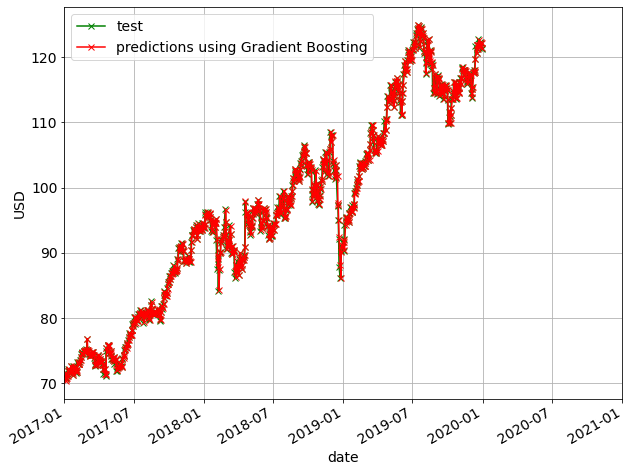

In [144]:

rcParams['figure.figsize'] = 10, 8 
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using Gradient Boosting'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 1, 1), date(2021, 1, 1)])
